In [1]:
import pandas as pd
import numpy as np

import lib.draw as draw
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.neural_network import MLPClassifier
import optuna
from sklearn.metrics import mean_squared_error
import pickle

from tqdm import tqdm

In [2]:
# Ajust to create denser maps
densityX, densityY = 1.5, 2.25

In [3]:
df = pd.read_csv('data/formated_data.csv').drop('Unnamed: 0', axis = 1)

In [4]:
df = df[df.type == 'TakeOn']
df

type  player  team  success      x      y  endX  endY  isShot  \
110     TakeOn  114597  2188        1  0.715  0.296   NaN   NaN   False   
118     TakeOn  322854  2187        0  0.786  0.785   NaN   NaN   False   
142     TakeOn  322852  2187        0  0.424  0.602   NaN   NaN   False   
146     TakeOn  322852  2187        0  0.624  0.439   NaN   NaN   False   
165     TakeOn  105745  2188        1  0.512  0.968   NaN   NaN   False   
...        ...     ...   ...      ...    ...    ...   ...   ...     ...   
243594  TakeOn   24030   297        1  0.516  0.113   NaN   NaN   False   
243746  TakeOn  291653   108        0  0.668  0.106   NaN   NaN   False   
243747  TakeOn  291653   108        0  0.821  0.017   NaN   NaN   False   
243753  TakeOn  322636   108        0  0.785  0.590   NaN   NaN   False   
243762  TakeOn   94891   297        1  0.639  0.348   NaN   NaN   False   

        isGoal  ...  cross  layOff  regularPlay  rebound  xrebound  yrebound  \
110      False  ...  False   False        False    False      -1.0      -1.0   
118      False  ...  False   False        False    False      -1.0      -1.0   
142      False  ...  False   False        False    False      -1.0      -1.0   
146      False  ...  False   False        False    False      -1.0      -1.0   
165      False  ...  False   False        False    False      -1.0      -1.0   
...        ...  ...    ...     ...          ...      ...       ...       ...   
243594   False  ...  False   False        False    False      -1.0      -1.0   
243746   False  ...  False   False        False    False      -1.0      -1.0   
243747   False  ...  False   False        False    False      -1.0      -1.0   
243753   False  ...  False   False        False    False      -1.0      -1.0   
243762   False  ...  False   False        False    False      -1.0      -1.0   

        xdribble  ydribble  toFoul  toCorner  
110        0.740     0.244    True     False  
118        0.219     0.226   False     False  
142        0.475     0.600   False     False  
146        0.141     0.744   False     False  
165        0.612     0.968   False     False  
...          ...       ...     ...       ...  
243594     0.529     0.132   False     False  
243746     0.711     0.032   False     False  
243747     0.553     0.177   False     False  
243753     0.771     0.496   False     False  
243762     0.639     0.345   False     False  

[9674 rows x 27 columns]

# Generate gradients

In [5]:
def plot_xdmap(xdmap, fromX, fromY):
    draw.pitch()
    cmap = np.zeros((len(xdmap),4))
    cmap[:,0] = 1; cmap[:,1] = 1; cmap[:,2] = 1; cmap[:,3] = xdmap.xd
    plt.scatter(xdmap.endX, xdmap.endY, s = 15, c = cmap, marker = 's', linewidth=0, zorder = 10)
    plt.scatter(fromX, fromY, s = 15, c = 'purple', marker = 's', linewidth=0, zorder = 11)

In [6]:
def plot_map(clf, fromX, fromY):
    xdmap = [[fromX/100, fromY/100, i/100, j/100] for i in range(0, 100) for j in np.arange(0, 100, 1.5)]
    xdmap = pd.DataFrame(xdmap, columns=['x','y', 'endX', 'endY'])
    xdmap['xd'] = clf.predict_proba(xdmap[['x','y', 'endX', 'endY']])[:,0]

    xdmap.x *= 100
    xdmap.y *= 100
    xdmap.endX *= 100
    xdmap.endY *= 100

    plot_xdmap(xdmap, fromX, fromY)

## Optimization
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 5)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int('n_units_l{}'.format(i), 4, 128))

    activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    lr = trial.suggest_float('learning_rate', 0.00001, 0.05)
    lr_type = trial.suggest_categorical('learning_rate_type', ['constant', 'invscaling', 'adaptive'])
    max_iterations = trial.suggest_int('epochs', 20, 750)
    early_stop = trial.suggest_categorical('early_stop', [False, True])
    
    clf = MLPClassifier(hidden_layer_sizes=layers, activation=activation, learning_rate_init=lr, learning_rate=lr_type, max_iter=max_iterations, early_stopping=early_stop)
    clf.fit(df[['x', 'y', 'xdribble', 'ydribble']], df['success'])

    pred = clf.predict_proba(df[['x', 'y', 'xdribble', 'ydribble']])[:,1]

    return mean_squared_error(pred, df['success'])

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
study.best_params

In [7]:
clf = MLPClassifier(hidden_layer_sizes=[64, 64, 64, 64, 64], activation='relu', learning_rate_init=0.001425740966620266, learning_rate='adaptive', max_iter=500)
clf.fit(df[['x', 'y', 'xdribble', 'ydribble']], df['success'])
pickle.dump(clf, open('matrix/D.sav', 'wb'))

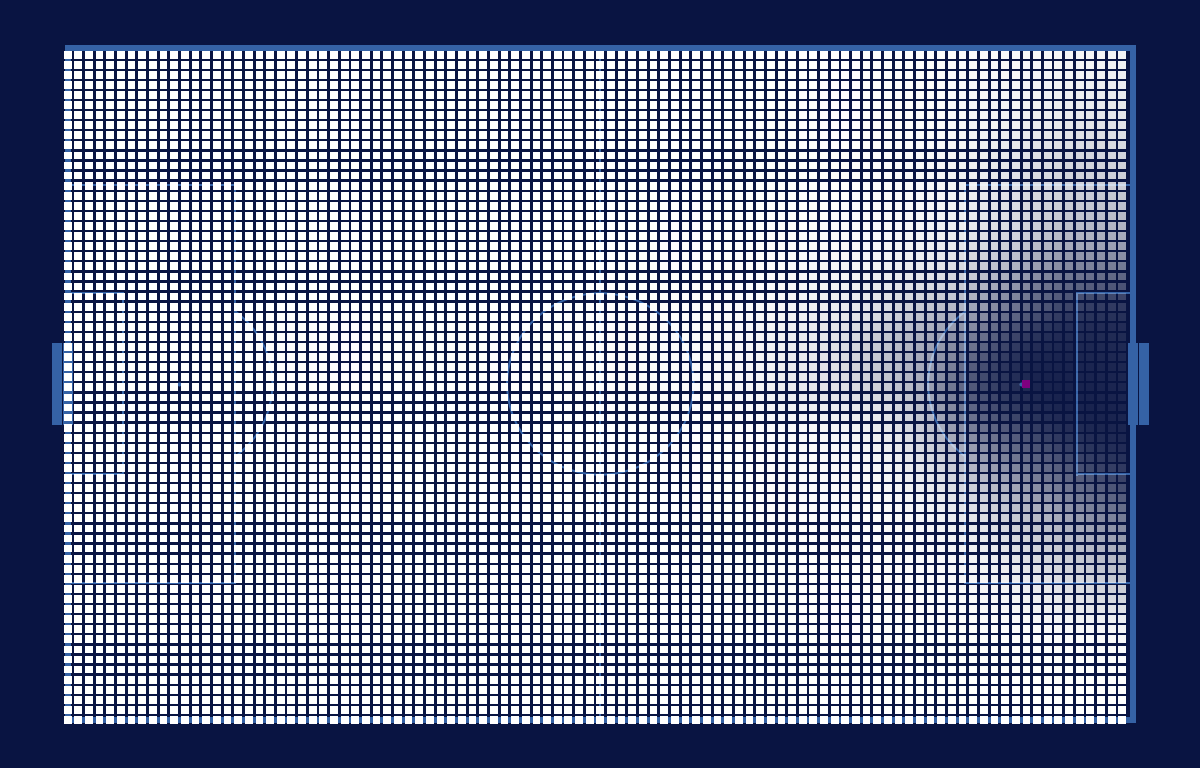

In [8]:
plot_map(clf, 90, 50)

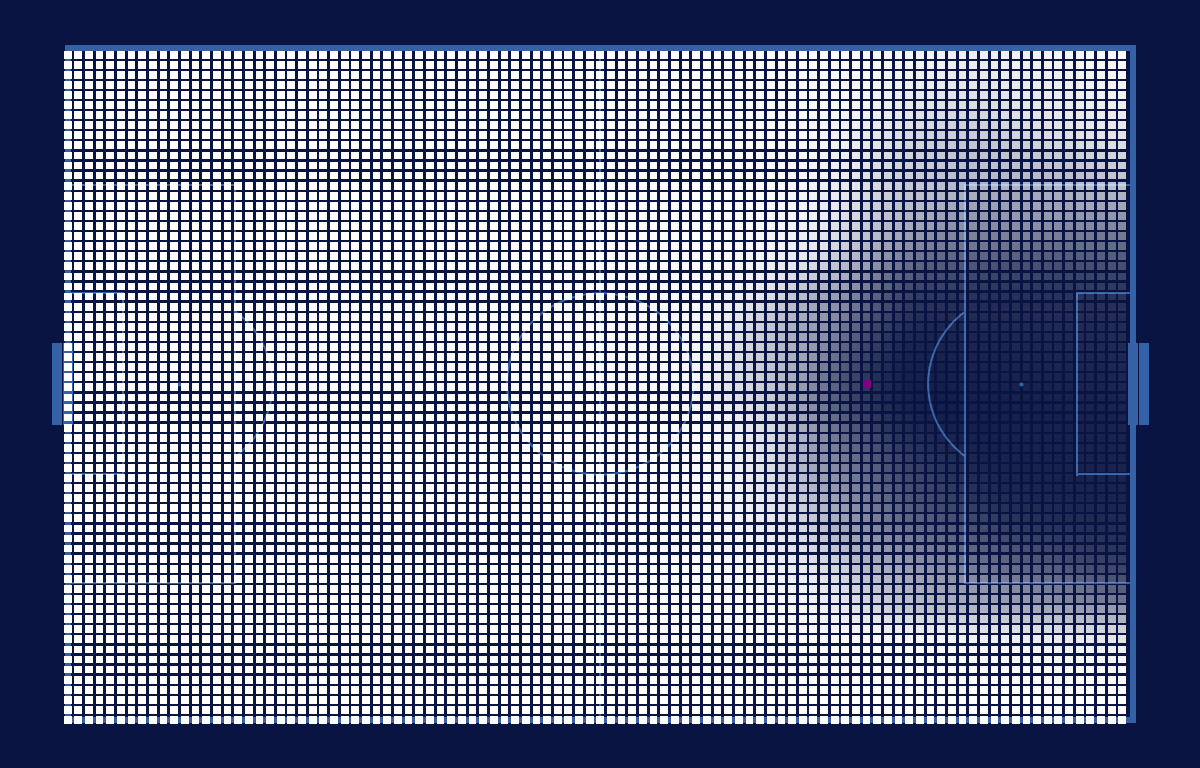

In [9]:
plot_map(clf, 75, 50)

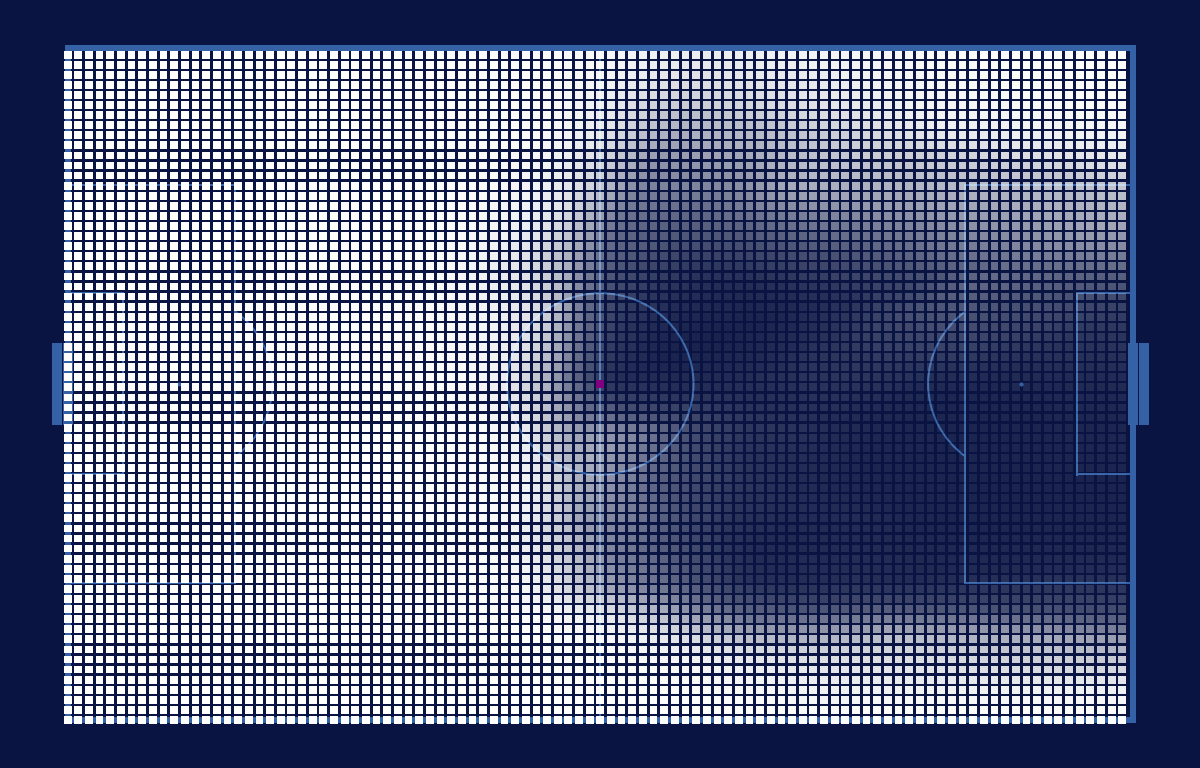

In [10]:
plot_map(clf, 50, 50)

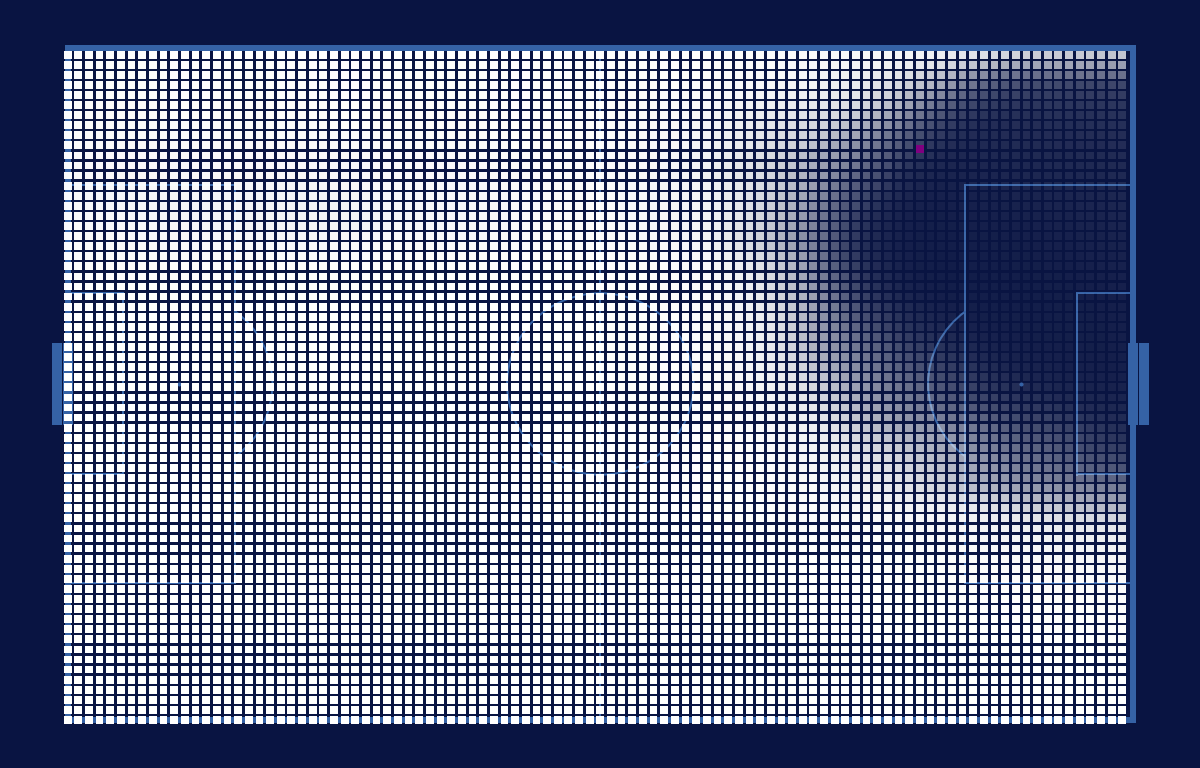

In [11]:
plot_map(clf, 80, 85)

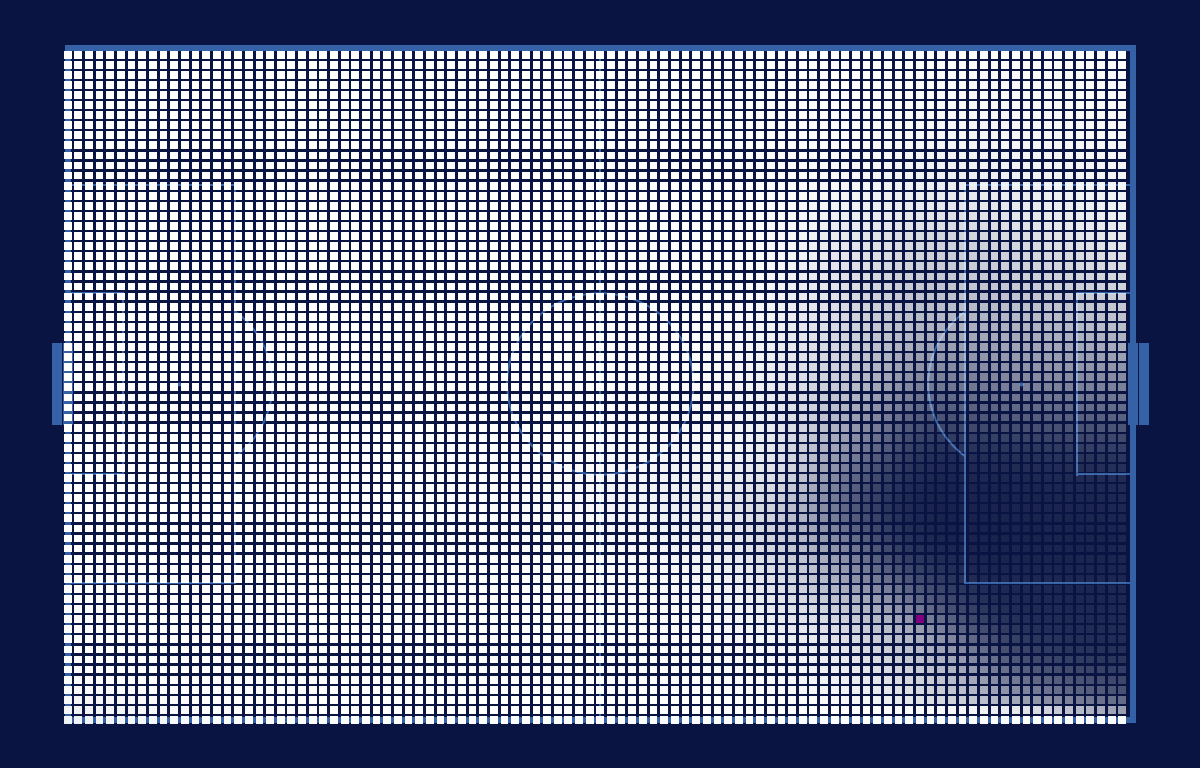

In [12]:
plot_map(clf, 80, 15)

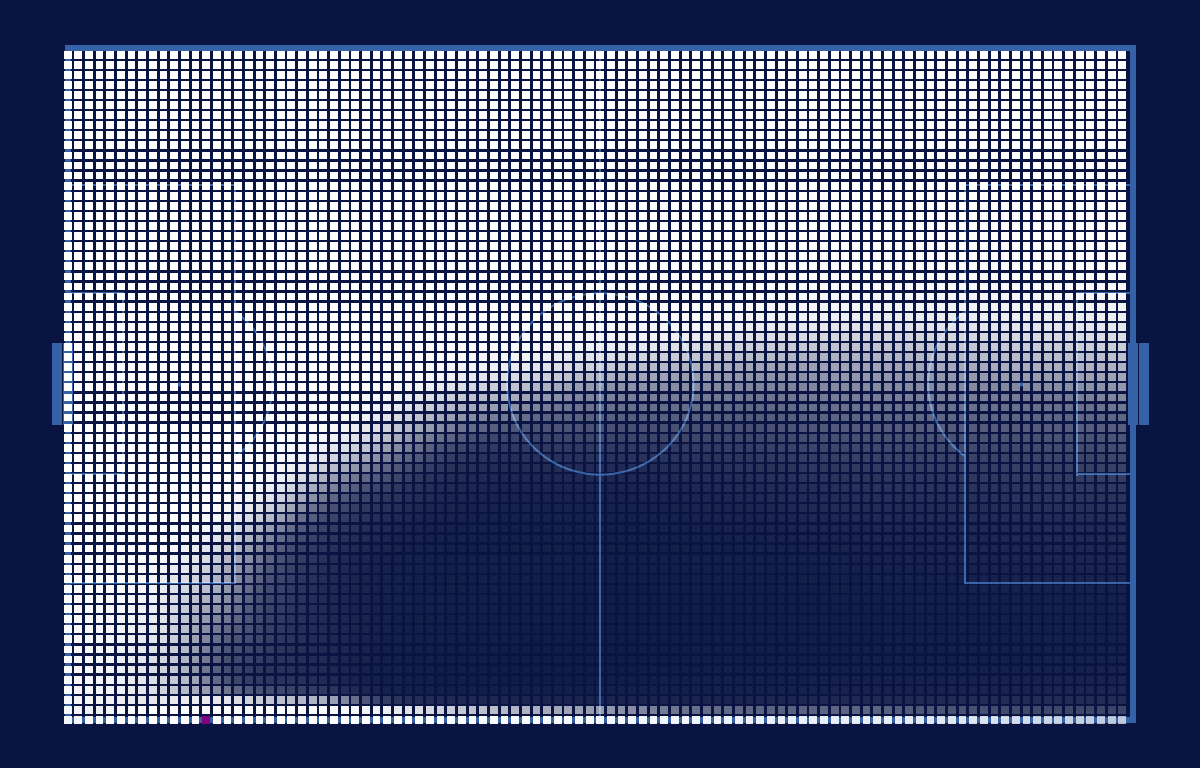

In [13]:
plot_map(clf, 13, 0)